In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd ../gdrive/MyDrive/CSE_575/

/gdrive/.shortcut-targets-by-id/1ZOjaaJR6FUgi-AiS0aWel7Gqn2TpkqgW/CSE_575


In [3]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Activation 
from sklearn.metrics import classification_report as cr, confusion_matrix as cm

In [4]:
# Helper Functions
def load_data():
    ohe = OneHotEncoder(sparse_output=False)
    X = np.load("X.npy")[:,:,:,:3]
    y = np.load("y.npy")
    y = ohe.fit_transform(y.reshape(-1,1))
    labels = ohe.categories_[0]
    # X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)
    return X_train, X_val, X_test, y_train, y_val, y_test, labels

In [5]:
# Loading Data
X_train, X_val, X_test, y_train, y_val, y_test, labels = load_data()

In [6]:
# Model Definition
model_layers = [
    Conv2D(64, (3, 3), input_shape=(288, 432, 3)),
    MaxPool2D(pool_size=(3, 3)),

    Conv2D(32, (3, 3)),
    MaxPool2D(pool_size=(3, 3)),

    Conv2D(32, (3, 3)),
    MaxPool2D(pool_size=(3, 3)),

    Dropout(0.3),
    Flatten(),

    Dense(10, activation="softmax")
]

model = Sequential(model_layers)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 286, 430, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 143, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 93, 141, 32)       18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 45, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 15, 32)        0

In [7]:
# Model Training
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=10, epochs=20)
print(f"Model Performance on Training Data: {model.evaluate(X_train,y_train)}")

Epoch 1/20
60/60 [==============================] - 12s 100ms/step - loss: 2.2482 - accuracy: 0.1920 - val_loss: 1.9818 - val_accuracy: 0.2550
Epoch 2/20
60/60 [==============================] - 4s 67ms/step - loss: 1.7729 - accuracy: 0.3756 - val_loss: 1.4775 - val_accuracy: 0.4750
Epoch 3/20
60/60 [==============================] - 4s 67ms/step - loss: 1.4634 - accuracy: 0.4775 - val_loss: 1.3688 - val_accuracy: 0.5150
Epoch 4/20
60/60 [==============================] - 5s 76ms/step - loss: 1.2667 - accuracy: 0.5710 - val_loss: 1.4231 - val_accuracy: 0.5150
Epoch 5/20
60/60 [==============================] - 4s 72ms/step - loss: 1.0713 - accuracy: 0.6260 - val_loss: 1.0870 - val_accuracy: 0.6300
Epoch 6/20
60/60 [==============================] - 4s 73ms/step - loss: 0.9572 - accuracy: 0.6845 - val_loss: 1.2864 - val_accuracy: 0.5800
Epoch 7/20
60/60 [==============================] - 5s 76ms/step - loss: 0.7842 - accuracy: 0.7129 - val_loss: 1.0569 - val_accuracy: 0.6650
Epoch 8/20


In [8]:
pred = model.predict(X_test)
pred = (pred>0.5)

print(cr(y_test,pred))
conf_m = cm(np.argmax(y_test,axis=1),np.argmax(pred,axis=1))
print(conf_m)

7/7 [==============================] - 1s 88ms/step
              precision    recall  f1-score   support

           0       0.59      0.73      0.66        26
           1       0.94      1.00      0.97        16
           2       0.30      0.27      0.29        11
           3       0.61      0.70      0.65        20
           4       0.95      0.70      0.81        27
           5       0.64      0.75      0.69        12
           6       0.94      0.71      0.81        21
           7       0.68      0.72      0.70        18
           8       0.78      0.58      0.67        24
           9       0.65      0.52      0.58        25

   micro avg       0.71      0.68      0.69       200
   macro avg       0.71      0.67      0.68       200
weighted avg       0.73      0.68      0.69       200
 samples avg       0.68      0.68      0.68       200

[[20  0  1  1  0  2  0  0  0  2]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 6  0  3  0  0  1  0  0  0  1]
 [ 2  0  1 14  0  0  0  2  1  0]
 [ 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


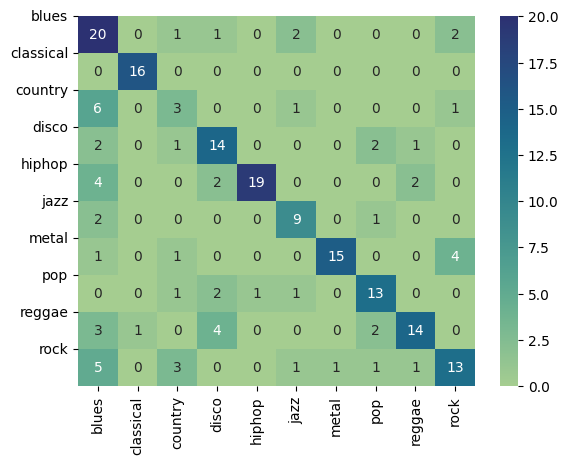

In [9]:
import seaborn as sns
from seaborn import heatmap
heatmap(conf_m,cmap="crest",annot=True)
plt.xticks(ticks = np.arange(0.5,10,1), labels=labels, rotation=90)
plt.yticks(ticks = np.arange(0,10,1), labels=labels,rotation=0)
plt.show()

In [10]:
class_acc = conf_m.diagonal()/conf_m.sum(axis=1)
for i in range(len(labels)):
  print(f"Class Accuracy for {labels[i]}: {round(class_acc[i],2)}")
print(f"\n**Total Accuracy : {np.trace(conf_m)/np.sum(conf_m)}**")

Class Accuracy for blues: 0.77
Class Accuracy for classical: 1.0
Class Accuracy for country: 0.27
Class Accuracy for disco: 0.7
Class Accuracy for hiphop: 0.7
Class Accuracy for jazz: 0.75
Class Accuracy for metal: 0.71
Class Accuracy for pop: 0.72
Class Accuracy for reggae: 0.58
Class Accuracy for rock: 0.52

**Total Accuracy : 0.68**
